In [1]:
# Setup environment
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/Othercomputers/My_Mac/sentinel')

import os
os.chdir('/content/drive/Othercomputers/My_Mac/sentinel')

# Install required packages
!pip install -q torch torchvision tensorboard google-cloud-storage tqdm scikit-learn matplotlib seaborn


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Imports
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import DataLoader
import json
from datetime import datetime

# Custom modules
from src.python.models.pointnet2 import PointNet2SemanticSegmentation
from src.python.datasets.semantic_kitti import SemanticKITTIDataset
from src.python.utils.metrics import (
    calculate_iou, calculate_accuracy, calculate_precision_recall,
    calculate_fpr, calculate_confusion_matrix, MetricTracker,
    robustness_score, print_metrics
)
from src.python.utils.visualization import (
    plot_confusion_matrix, plot_per_class_metrics,
    visualize_pointcloud, create_comparison_figure
)
from src.python.config.training_config import TrainingConfig


In [3]:
# Load configuration
config = TrainingConfig()

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Class names for SemanticKITTI (20 classes)
CLASS_NAMES = [
    'unlabeled', 'car', 'bicycle', 'motorcycle', 'truck',
    'other-vehicle', 'person', 'bicyclist', 'motorcyclist', 'road',
    'parking', 'sidewalk', 'other-ground', 'building', 'fence',
    'vegetation', 'trunk', 'terrain', 'pole', 'traffic-sign'
]


Using device: cpu


In [4]:
# Load the trained model
model = PointNet2SemanticSegmentation(num_classes=config.get('model.num_classes'))

# Load best checkpoint
checkpoint_path = os.path.join(config.get('paths.checkpoint_dir'), 'best_model.pth')

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from epoch {checkpoint['epoch']}")
    print(f"Best validation accuracy: {checkpoint.get('val_acc', 0):.4f}")
else:
    print(f"No checkpoint found at {checkpoint_path}")
    print("Please train the model first using 03_pointnet_training.ipynb")

model = model.to(device)
model.eval()


Loaded model from epoch 1
Best validation accuracy: 0.6127


PointNet2SemanticSegmentation(
  (sa1): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (sa2): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(67, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (sa3): PointNe

In [14]:
from google.colab import auth
auth.authenticate_user()

from torch.utils.data import Subset

# Step 1: Create the full test dataset
test_dataset_full = SemanticKITTIDataset(
    root_dir=config.get('paths.data_dir'),
    split='val',  # Using validation as test for now
    use_gcs=True,
    bucket_name=config.get('gcs.bucket_name'),
    use_intensity=True
)

# Step 2: Limit it to first 100 samples
test_dataset = Subset(test_dataset_full, range(100))

# Step 3: Create the dataloader
test_loader = DataLoader(
    test_dataset,
    batch_size=1,  # Batch size 1 for variable-length point clouds
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Test dataset size: {len(test_dataset)} samples")


Test dataset size: 100 samples


In [15]:
# Evaluation function
def evaluate_model(model, dataloader, device, num_classes=20):
    model.eval()
    metric_tracker = MetricTracker(num_classes=num_classes, ignore_index=-1)
    all_predictions, all_labels = [], []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Evaluating")
        for batch_idx, (points, labels) in enumerate(pbar):
            points = points.to(device)
            labels = labels.to(device)

            predictions = model(points)
            pred_labels = predictions.argmax(dim=-1)

            metric_tracker.update(pred_labels, labels)

            all_predictions.append(pred_labels.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            if batch_idx % 10 == 0:
                current_metrics = metric_tracker.get_metrics()
                pbar.set_postfix({
                    'acc': f"{current_metrics['accuracy']:.3f}",
                    'mIoU': f"{current_metrics['mean_iou']:.3f}"
                })

    metrics = metric_tracker.get_metrics()
    all_predictions = np.concatenate(all_predictions, axis=0).flatten()
    all_labels = np.concatenate(all_labels, axis=0).flatten()
    return metrics, all_predictions, all_labels


In [16]:
# Run evaluation
print("Starting model evaluation...")
metrics, all_predictions, all_labels = evaluate_model(model, test_loader, device)

# Add robustness score
metrics['robustness_score'] = robustness_score(metrics, alpha=0.5, beta=0.5)

# Print results
print_metrics(metrics, class_names=CLASS_NAMES, detailed=True)


Starting model evaluation...


Evaluating: 100%|██████████| 100/100 [16:30<00:00,  9.91s/it, acc=0.511, mIoU=0.130]



EVALUATION METRICS

Overall Metrics:
  Accuracy:        0.5070
  Mean IoU:        0.1306
  Mean Precision:  0.4677
  Mean Recall:     0.2000
  Mean FPR:        0.0294
  Mean F1:         0.3440
  Robustness:      0.5506

Per-Class Metrics:
------------------------------------------------------------
Class                IoU        Precision  Recall     F1        
------------------------------------------------------------
unlabeled            0.3476     0.8127     0.3779     0.5159    
car                  0.2777     0.3858     0.4977     0.4346    
bicycle              0.0000     nan        0.0000     nan       
motorcycle           N/A        N/A        N/A        N/A       
truck                N/A        N/A        N/A        N/A       
other-vehicle        N/A        N/A        N/A        N/A       
person               0.0000     nan        0.0000     nan       
bicyclist            0.0000     nan        0.0000     nan       
motorcyclist         N/A        N/A        N/A       

/tmp/ipython-input-3794673342.py:5: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)


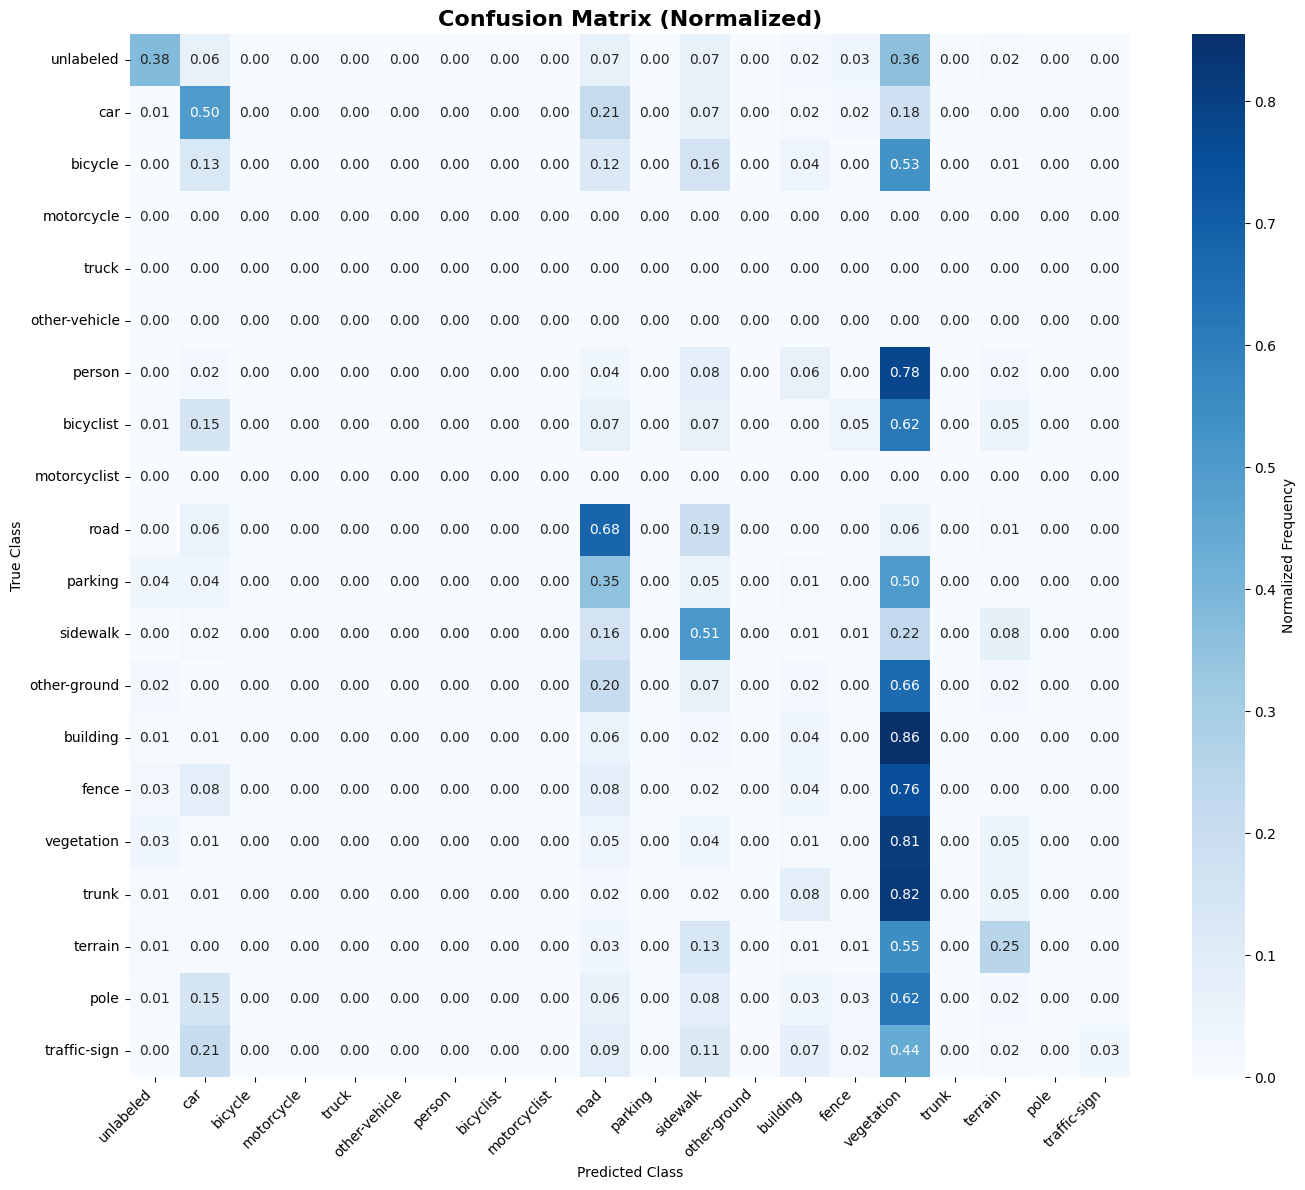

In [17]:
# Plot confusion matrix
plt.figure(figsize=(14, 12))
cm = confusion_matrix(all_labels, all_predictions, labels=list(range(20)))

cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
cm_normalized = np.nan_to_num(cm_normalized)

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Normalized Frequency'})
plt.title('Confusion Matrix (Normalized)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('evaluation_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


Per-class metrics plot saved to evaluation_per_class_metrics.png


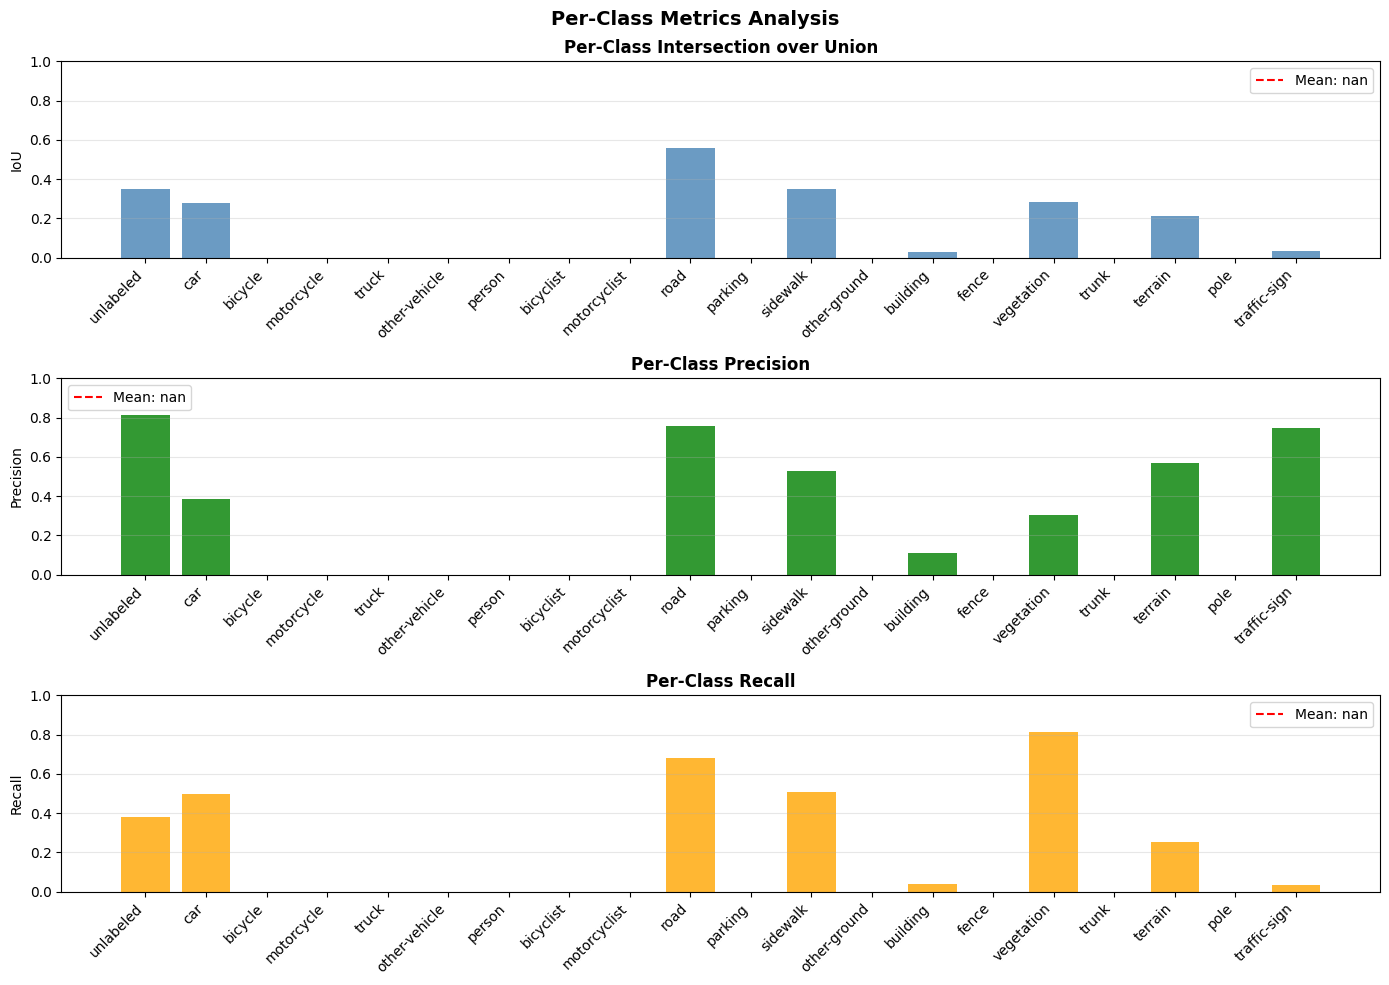

In [18]:
# Plot per-class metrics
plot_per_class_metrics(
    metrics,
    class_names=CLASS_NAMES,
    save_path='evaluation_per_class_metrics.png',
    figsize=(14, 10)
)


In [20]:
# Analyze failure cases
def analyze_failure_cases(predictions, labels, class_names):
    misclassified = predictions != labels

    error_rates = {}
    for cls in range(len(class_names)):
        cls_mask = labels == cls
        if cls_mask.sum() > 0:
            error_rate = misclassified[cls_mask].mean()
            error_rates[class_names[cls]] = error_rate

    sorted_errors = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)

    print("\nTop 5 Classes with Highest Error Rates:")
    print("-" * 40)
    for cls_name, error_rate in sorted_errors[:5]:
        print(f"{cls_name:<20} {error_rate:.3%}")

    print("\nTop Confusion Pairs:")
    print("-" * 40)
    cm = confusion_matrix(labels, predictions, labels=list(range(len(class_names))))
    confusion_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((class_names[i], class_names[j], cm[i, j]))
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    for true_cls, pred_cls, count in confusion_pairs[:5]:
        print(f"{true_cls:<15} → {pred_cls:<15} : {count:,} points")

analyze_failure_cases(all_predictions, all_labels, CLASS_NAMES)



Top 5 Classes with Highest Error Rates:
----------------------------------------
bicycle              100.000%
person               100.000%
bicyclist            100.000%
parking              100.000%
other-ground         100.000%

Top Confusion Pairs:
----------------------------------------
terrain         → vegetation      : 412,354 points
road            → sidewalk        : 274,983 points
sidewalk        → vegetation      : 224,025 points
unlabeled       → vegetation      : 174,388 points
sidewalk        → road            : 161,346 points


Visualizing sample predictions...


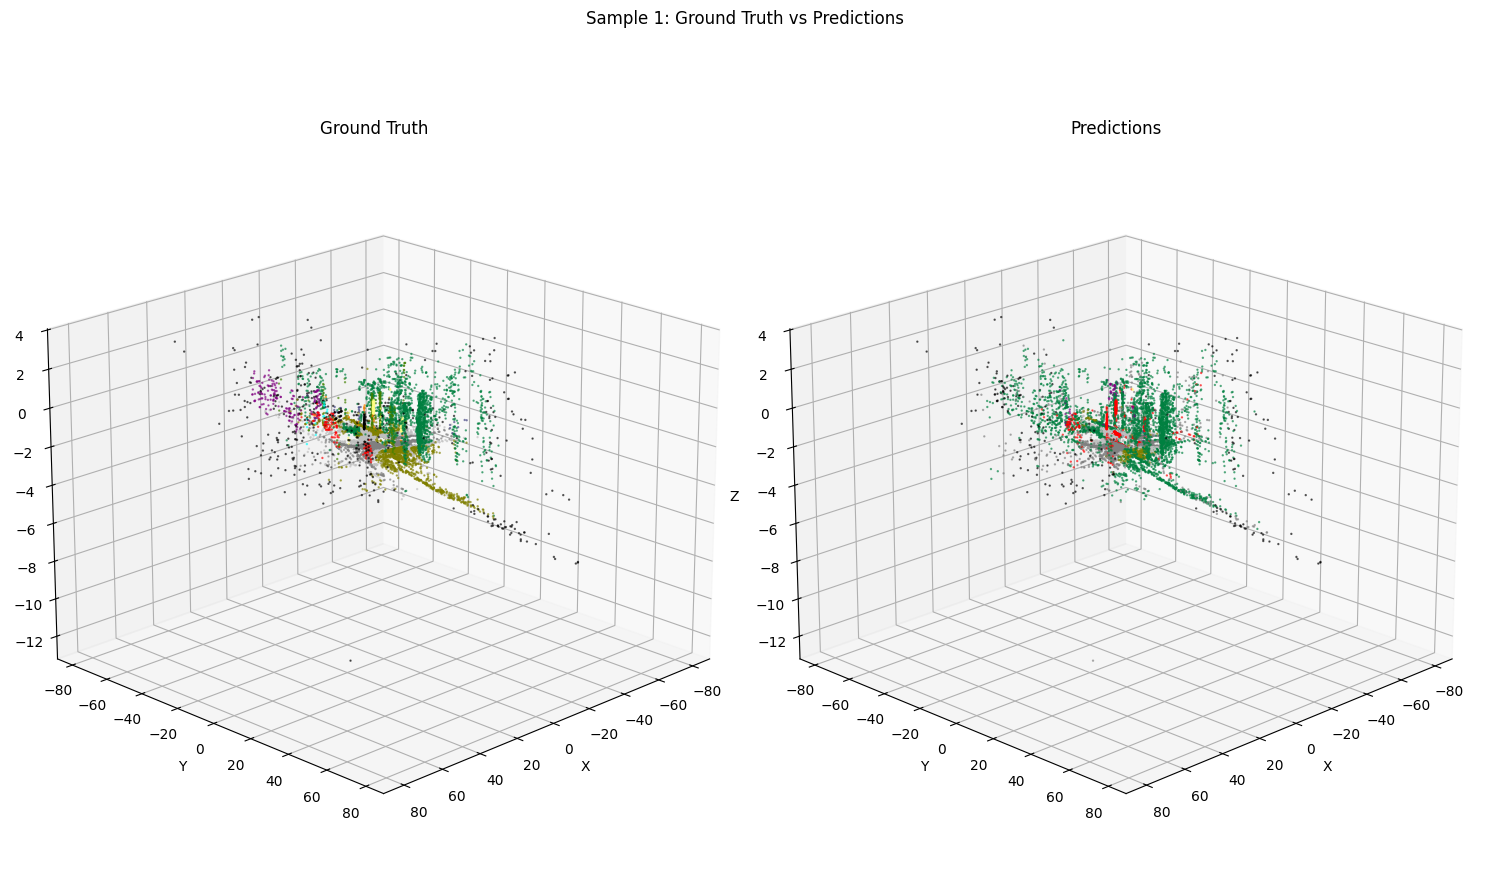

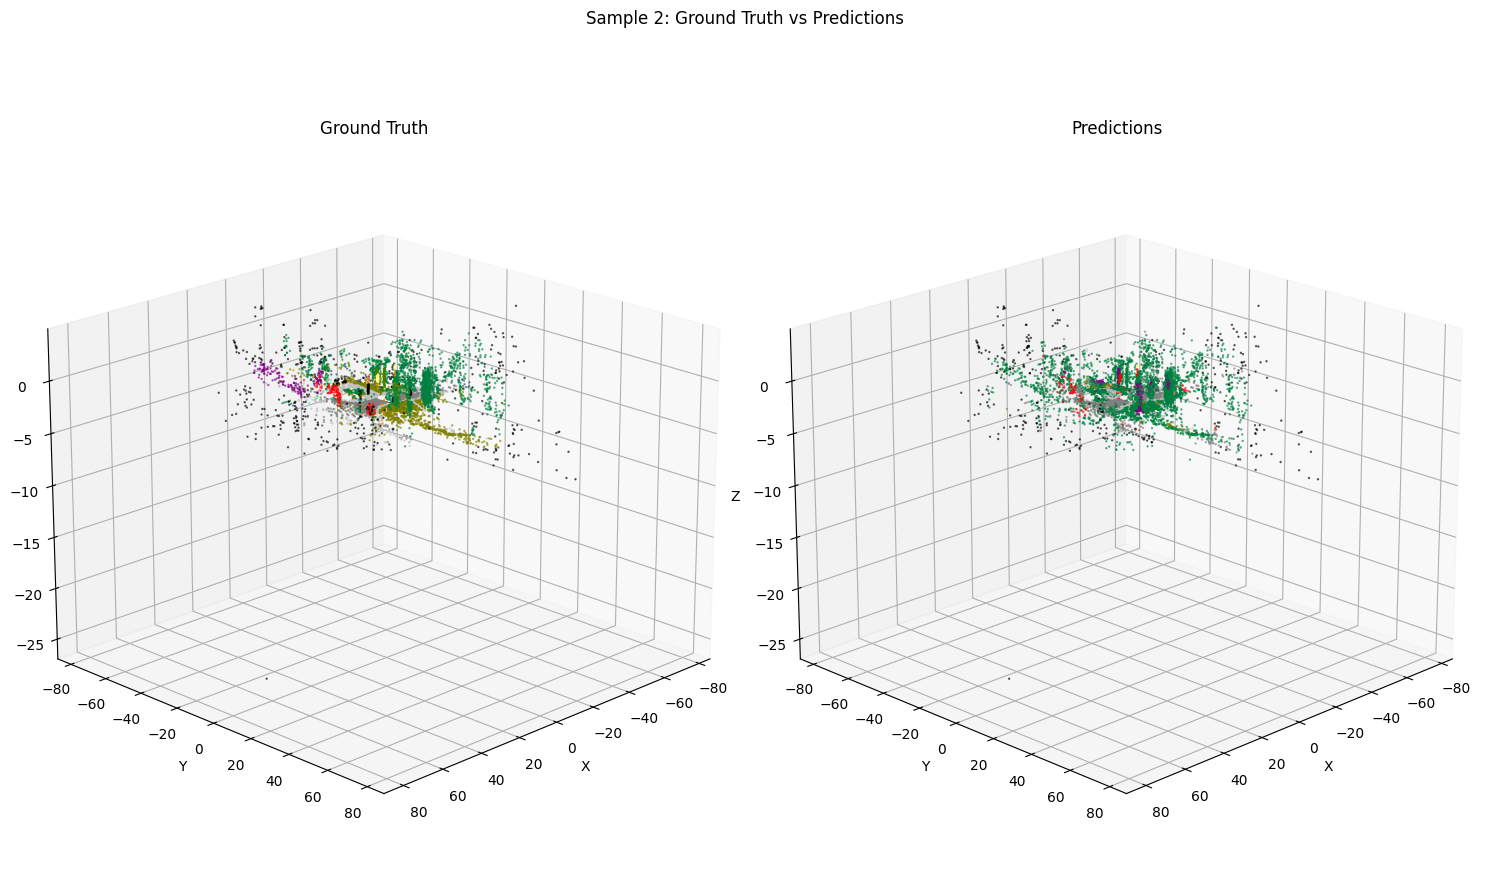

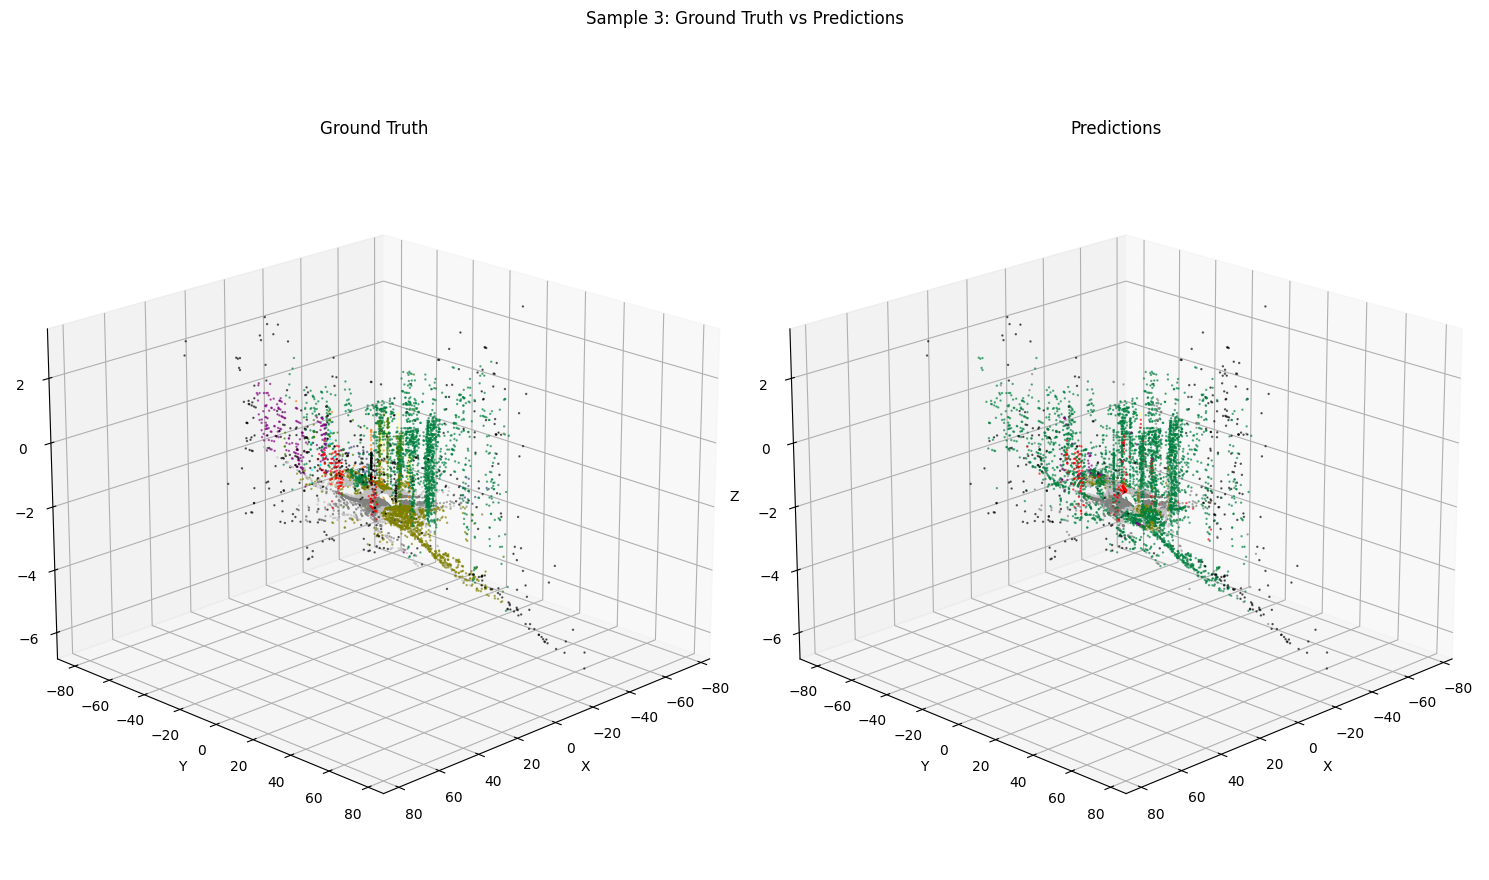

In [21]:
# Visualize sample predictions
def visualize_sample_predictions(model, dataset, device, num_samples=3):
    model.eval()
    for i in range(min(num_samples, len(dataset))):
        points, labels = dataset[i]
        points = points.unsqueeze(0).to(device)
        with torch.no_grad():
            predictions = model(points)
            pred_labels = predictions.argmax(dim=-1)
        points_np = points[0, :, :3].cpu().numpy()
        labels_np = labels.cpu().numpy()
        pred_labels_np = pred_labels[0].cpu().numpy()

        visualize_pointcloud(
            points_np,
            labels=labels_np,
            predictions=pred_labels_np,
            title=f"Sample {i+1}: Ground Truth vs Predictions",
            max_points=10000,
            use_open3d=False
        )

print("Visualizing sample predictions...")
visualize_sample_predictions(model, test_dataset, device, num_samples=3)


In [22]:
# Save evaluation results
results = {
    'timestamp': datetime.now().isoformat(),
    'model_checkpoint': checkpoint_path,
    'dataset_split': 'validation',
    'overall_metrics': {
        'accuracy': float(metrics['accuracy']),
        'mean_iou': float(metrics['mean_iou']),
        'mean_precision': float(metrics['mean_precision']),
        'mean_recall': float(metrics['mean_recall']),
        'mean_fpr': float(metrics['mean_fpr']),
        'mean_f1': float(metrics['mean_f1']),
        'robustness_score': float(metrics['robustness_score'])
    },
    'per_class_iou': {CLASS_NAMES[i]: float(iou) if not np.isnan(iou) else None
                      for i, iou in enumerate(metrics['per_class_iou'])},
    'per_class_precision': {CLASS_NAMES[i]: float(p) if not np.isnan(p) else None
                            for i, p in enumerate(metrics['per_class_precision'])},
    'per_class_recall': {CLASS_NAMES[i]: float(r) if not np.isnan(r) else None
                         for i, r in enumerate(metrics['per_class_recall'])},
    'per_class_fpr': {CLASS_NAMES[i]: float(fpr) for i, fpr in enumerate(metrics['per_class_fpr'])}
}

results_path = os.path.join(config.get('paths.log_dir'), 'evaluation_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nEvaluation results saved to: {results_path}")
print("\n" + "="*60)
print("EVALUATION COMPLETE")
print("="*60)
print(f"Overall Accuracy: {metrics['accuracy']:.3%}")
print(f"Mean IoU: {metrics['mean_iou']:.3%}")
print(f"Mean FPR: {metrics['mean_fpr']:.3%}")
print(f"Robustness Score: {metrics['robustness_score']:.3f}")



Evaluation results saved to: /content/drive/MyDrive/project-sentinel/logs/evaluation_results.json

EVALUATION COMPLETE
Overall Accuracy: 50.697%
Mean IoU: 13.063%
Mean FPR: 2.944%
Robustness Score: 0.551
